In [ ]:
import torch
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import os
import random


Importing data and systematically organisation into folders 

In [ ]:
input_dir = "./archive (5)"

for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./archive (5)\anger\11647173796_033ff06112_n_face.png
./archive (5)\anger\1379351899_7cfa2b0dc4_b_face.png
./archive (5)\anger\14187801814_ea89208940_b_face.png
./archive (5)\anger\22600236939_54d0e01905_n_face.png
./archive (5)\anger\22721287949_65572bea8b_n_face.png
./archive (5)\anger\22913025801_2822113219_n_face.png
./archive (5)\anger\24063912157_38a4f8d093_b_face.png
./archive (5)\anger\2971847861_5c6fe61308_b_face.png
./archive (5)\anger\2Q__ (1)_face.png
./archive (5)\anger\2Q__ (2)_face.png
./archive (5)\anger\2Q__ (3)_face.png
./archive (5)\anger\2Q__ (5)_face.png
./archive (5)\anger\2Q___face.png
./archive (5)\anger\30313832521_d63b8e0dcb_b_face.png
./archive (5)\anger\31049558135_aba6aa9495_n_face.png
./archive (5)\anger\31779682004_a9efa7d01e_n_face.png
./archive (5)\anger\32389337586_9f0fb42512_n_face.png
./archive (5)\anger\33824758533_a82fc5b885_b_face.png
./archive (5)\anger\372662640_e8dc799d8b_b_face.png
./archive (5)\anger\4604139529_c23a5a462a_n_face.png
./archive

Demarcating disjoint classes and displaying class distribution

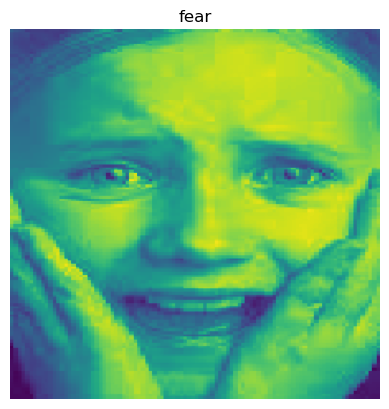

In [ ]:
# Define the directories for each emotion, using forward slashes
emotion_dirs = {
   'fear': './archive (5)/fear/',
    'happiness': './archive (5)/happiness/',
    'neutrality': './archive (5)/neutrality/',
    'sadness': './archive (5)/sadness/',
    'surprise': './archive (5)/surprise/'
}

# List to hold image paths and their corresponding emotion labels
image_data = []

# Loop through each directory and collect image paths with their emotion labels
for emotion, dir_path in emotion_dirs.items():
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.png'):  # Adjust extensions as necessary
            image_path = os.path.join(dir_path, file_name)
            image_data.append([image_path, emotion])

# Create a DataFrame with two columns: 'image_path' and 'emotion'
df = pd.DataFrame(image_data, columns=['image_path', 'emotion'])

# Function to load an image
def load_image(image_path):
    return Image.open(image_path)


example_image = load_image(df['image_path'][0])


plt.imshow(example_image)
plt.axis('off')  
plt.title(df['emotion'][0]) 
plt.show() 


In [3]:
df.head()

,image_path,emotion
0,./archive (5)/fear/2Q__ (2)_face.png,fear
1,./archive (5)/fear/2Q__ (3)_face.png,fear
2,./archive (5)/fear/2Q__ (4)_face.png,fear
3,./archive (5)/fear/2Q__ (5)_face.png,fear
4,./archive (5)/fear/2Q__ (6)_face.png,fear


In [ ]:
class_counts = Counter(df['emotion'])

# Display class frequencies
print("Class Frequencies:", class_counts)
class_df = pd.DataFrame(class_counts.items(), columns=['class', 'count'])

Class Frequencies: Counter({'happiness': 1406, 'surprise': 775, 'sadness': 746, 'fear': 570, 'neutrality': 524})


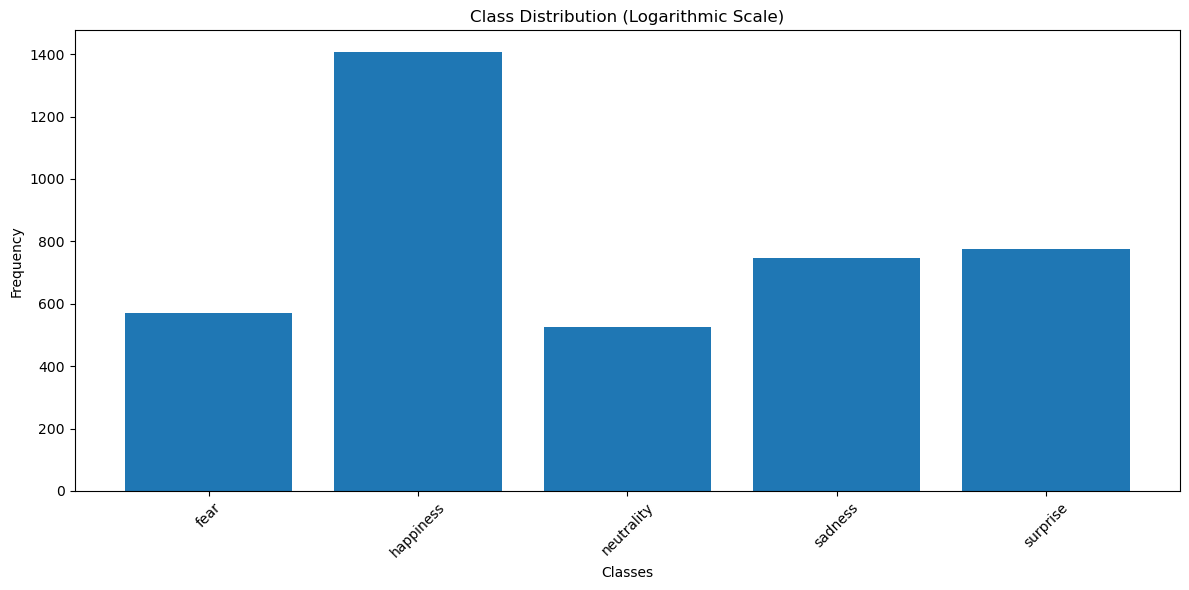

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(class_df['class'], class_df['count'])
plt.xticks(rotation=45)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution (Logarithmic Scale)')


plt.tight_layout()
plt.show()


In [ ]:
label_encoder = LabelEncoder()

# Perform label encoding and create a new column 'emotion_encoded'
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
df.head()

,image_path,emotion,emotion_encoded
0,./archive (5)/fear/2Q__ (2)_face.png,fear,0
1,./archive (5)/fear/2Q__ (3)_face.png,fear,0
2,./archive (5)/fear/2Q__ (4)_face.png,fear,0
3,./archive (5)/fear/2Q__ (5)_face.png,fear,0
4,./archive (5)/fear/2Q__ (6)_face.png,fear,0


doing data augmentation by adding images with slight modification such as flipping, rotating, etc. to create more copies to counter class imbalance 

In [ ]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
])


def augment_image(image_path, count):
    img = Image.open(image_path)
    augmented_img = augmentations(img)
    
    # Construct the new image name with '_aug' in the name
    base_name, ext = os.path.splitext(image_path)
    new_img_name = f"{base_name}_aug_{count}{ext}"
    
    augmented_img.save(new_img_name)
    
    return new_img_name, augmented_img

target_count = 1000

augmented_data = []
sample_augmented_images = []  

# Loop through each class in class_df and augment images
for index, row in class_df.iterrows():
    emotion = row['class']
    count = row['count']
    
    if count < target_count:
        class_images = df[df['emotion'] == emotion]['image_path'].tolist()
        images_needed = target_count - count
        
        # Randomly augment existing images to reach the target count
        for i in range(images_needed):
            img_path = random.choice(class_images)
            new_img_name, augmented_img = augment_image(img_path, i)
            
            # Add augmented data to the dataframe 
            augmented_data.append([new_img_name, emotion, df[df['image_path'] == img_path]['emotion_encoded'].values[0]])

            if len(sample_augmented_images) < 5:  
                sample_augmented_images.append(augmented_img)

# Create new DataFrame with augmented image paths
augmented_df = pd.DataFrame(augmented_data, columns=['image_path', 'emotion', 'emotion_encoded'])

# Append augmented data to the original DataFrame
balanced_df = pd.concat([df, augmented_df], ignore_index=True)

print("Class-wise augmentation completed and images saved.")



Class-wise augmentation completed and images saved.


In [ ]:

class_counts2 = Counter(balanced_df['emotion'])

print("Class Frequencies:", class_counts2)
class_df = pd.DataFrame(class_counts2.items(), columns=['class', 'count'])

Class Frequencies: Counter({'happiness': 1406, 'fear': 1000, 'neutrality': 1000, 'sadness': 1000, 'surprise': 1000})


Model definition and training

In [ ]:
mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet.eval()  # Set the model to evaluation mode

# Define preprocessing for MobileNet
mobilenet_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load and preprocess a batch of images
def preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = mobilenet_preprocess(img)
            images.append(img_tensor)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    
    return torch.stack(images) if images else None



In [10]:
balanced_df.isna().sum()

image_path         0
emotion            0
emotion_encoded    0
dtype: int64

Replacing its classifier layer with additional layers tailored for the number of emotion classes.
Freezing all pre-trained layers except the classifier to enable efficient fine-tuning.
Using Adam optimizer and CrossEntropyLoss to update the model’s classifier parameters.

In [ ]:
mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet.eval()  # Set the model to evaluation mode

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['emotion']
        
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        
        return img, label

def create_dataloader(dataframe, batch_size=10, shuffle=True):
    dataset = CustomImageDataset(dataframe, transform=mobilenet_preprocess)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

emotion_labels = label_encoder.classes_
encoded_label_mapping = {i: label for i, label in enumerate(emotion_labels)}
num_classes = len(emotion_labels)

# Update the final classifier layer of MobileNet with additional layers
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Dropout layer to prevent overfitting
    nn.Linear(mobilenet.classifier[1].in_features, 512),  # First added layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),  
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)  # Final layer with the number of classes in your dataset
)

# Freeze some layers for fine-tuning
for param in mobilenet.parameters():
    param.requires_grad = False

# Unfreeze the last few layers for training
for param in mobilenet.classifier.parameters():
    param.requires_grad = True

# Define the optimizer and loss function
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=1e-4)  
criterion = nn.CrossEntropyLoss()

# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['emotion'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['emotion'], random_state=42)

train_loader = create_dataloader(train_df)
val_loader = create_dataloader(val_df)
test_loader = create_dataloader(test_df)

# Training Loop with validation
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    mobilenet.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        labels_indices = torch.tensor(
            [list(encoded_label_mapping.keys())[list(encoded_label_mapping.values()).index(label)] for label in labels]
        )

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels_indices)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_classes = torch.max(outputs, dim=1)
        correct_predictions += (predicted_classes == labels_indices).sum().item()
        total_predictions += labels_indices.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    mobilenet.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels_indices = torch.tensor(
                [list(encoded_label_mapping.keys())[list(encoded_label_mapping.values()).index(label)] for label in labels]
            )

            outputs = mobilenet(images)
            loss = criterion(outputs, labels_indices)

            val_running_loss += loss.item()
            _, predicted_classes = torch.max(outputs, dim=1)
            val_correct_predictions += (predicted_classes == labels_indices).sum().item()
            val_total_predictions += labels_indices.size(0)

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")


Training Epoch 1/10: 100%|██████████| 325/325 [02:06<00:00,  2.56it/s]


Epoch 1/10, Train Loss: 1.5624, Train Acc: 0.2908, Val Loss: 1.5027, Val Acc: 0.3488


Training Epoch 2/10: 100%|██████████| 325/325 [02:09<00:00,  2.52it/s]


Epoch 2/10, Train Loss: 1.4399, Train Acc: 0.3842, Val Loss: 1.3683, Val Acc: 0.4255


Training Epoch 3/10: 100%|██████████| 325/325 [02:15<00:00,  2.40it/s]


Epoch 3/10, Train Loss: 1.3749, Train Acc: 0.4132, Val Loss: 1.3181, Val Acc: 0.4440


Training Epoch 4/10: 100%|██████████| 325/325 [02:09<00:00,  2.51it/s]


Epoch 4/10, Train Loss: 1.3369, Train Acc: 0.4379, Val Loss: 1.2968, Val Acc: 0.4468


Training Epoch 5/10: 100%|██████████| 325/325 [02:09<00:00,  2.50it/s]


Epoch 5/10, Train Loss: 1.3137, Train Acc: 0.4437, Val Loss: 1.2860, Val Acc: 0.4625


Training Epoch 6/10: 100%|██████████| 325/325 [02:09<00:00,  2.52it/s]


Epoch 6/10, Train Loss: 1.2975, Train Acc: 0.4567, Val Loss: 1.2664, Val Acc: 0.4829


Training Epoch 7/10: 100%|██████████| 325/325 [02:04<00:00,  2.61it/s]


Epoch 7/10, Train Loss: 1.2797, Train Acc: 0.4746, Val Loss: 1.2736, Val Acc: 0.4644


Training Epoch 8/10: 100%|██████████| 325/325 [02:00<00:00,  2.69it/s]


Epoch 8/10, Train Loss: 1.2713, Train Acc: 0.4706, Val Loss: 1.2591, Val Acc: 0.4783


Training Epoch 9/10: 100%|██████████| 325/325 [02:04<00:00,  2.62it/s]


Epoch 9/10, Train Loss: 1.2602, Train Acc: 0.4804, Val Loss: 1.2624, Val Acc: 0.4829


Training Epoch 10/10: 100%|██████████| 325/325 [02:01<00:00,  2.68it/s]


Epoch 10/10, Train Loss: 1.2515, Train Acc: 0.4743, Val Loss: 1.2646, Val Acc: 0.4829


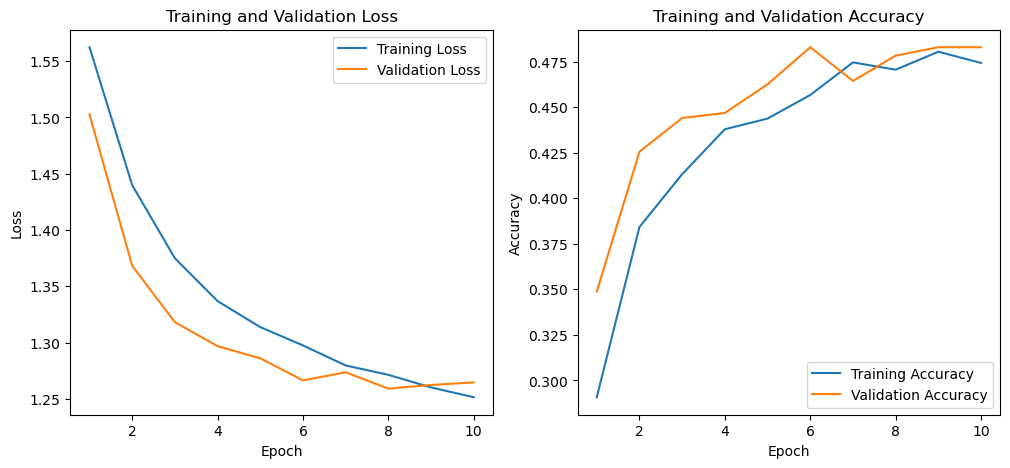

In [17]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


              precision    recall  f1-score   support

        fear       0.44      0.47      0.45       200
   happiness       0.46      0.77      0.58       282
  neutrality       0.54      0.48      0.51       200
     sadness       0.49      0.18      0.26       200
    surprise       0.52      0.38      0.44       200

    accuracy                           0.48      1082
   macro avg       0.49      0.46      0.45      1082
weighted avg       0.49      0.48      0.46      1082



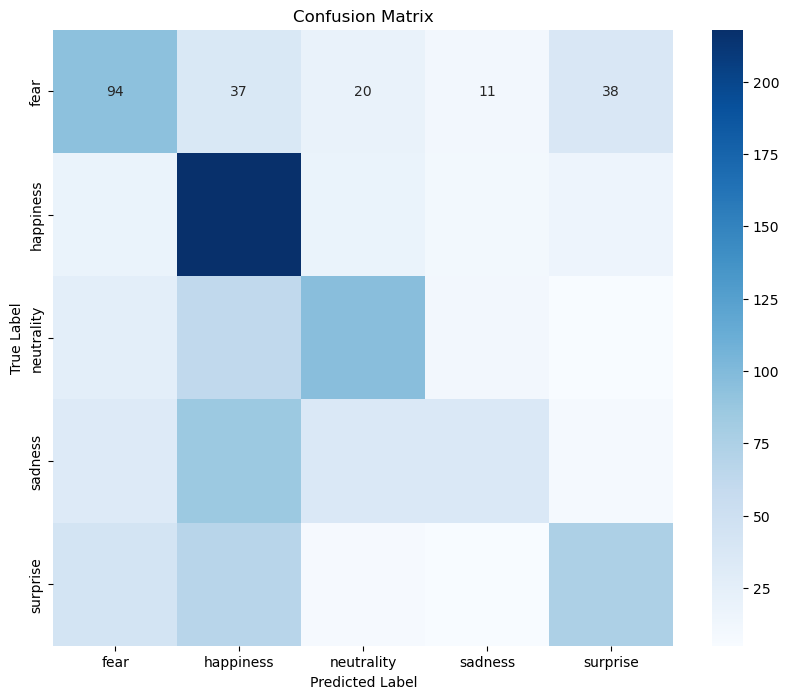

In [18]:
# Test Phase
mobilenet.eval()
test_labels = []
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels_indices = [list(encoded_label_mapping.keys())[list(encoded_label_mapping.values()).index(label)] for label in labels]
        test_labels.extend(labels_indices)

        outputs = mobilenet(images)
        _, predicted_classes = torch.max(outputs, dim=1)
        test_predictions.extend(predicted_classes.cpu().tolist())

# Classification report
print(classification_report(test_labels, test_predictions, target_names=emotion_labels))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix depicts that happiness was predicted with the most accuracy.Emotions such as fear, neutrality and surprise are predicted with moderate accuracy. However sadness was not predicted correctly, the model often classified sadness as happiness even more than sadness.

On earlier runs accuracy came out to be 49% however on adding the final layer, it went down a bit to roughly 48%